# 🌙 CL837 Sleep Data Analysis

Complete notebook for:
1. Connect to CL837 device via Bluetooth
2. UTC time synchronization
3. Download sleep data
4. Export to CSV
5. Visualize charts by night

**Requirements:** CL837 device powered on and nearby

In [20]:
# Imports
import asyncio
import time
import csv
from datetime import datetime, timezone, timedelta
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bleak import BleakClient, BleakScanner
import ast

# To run asyncio in Jupyter
import nest_asyncio
nest_asyncio.apply()

print("✅ Imports complete")

✅ Imports complete


## 📡 BLE Configuration

Chileaf protocol constants for Bluetooth Low Energy communication.

In [21]:
# Chileaf Protocol Constants
CHILEAF_SERVICE_UUID = "aae28f00-71b5-42a1-8c3c-f9cf6ac969d0"
CHILEAF_TX_UUID = "aae28f01-71b5-42a1-8c3c-f9cf6ac969d0"  # Notifications
CHILEAF_RX_UUID = "aae28f02-71b5-42a1-8c3c-f9cf6ac969d0"  # Write

CHILEAF_HEADER = 0xFF
CMD_SET_UTC = 0x08
CMD_GET_SLEEP = 0x05

# Validation
MIN_VALID_TIMESTAMP = 1577836800  # 2020-01-01

# Storage
all_records = []
data_complete = False
utc_confirmed = False

def calculate_checksum(data):
    """Calculate Chileaf checksum: ((0 - sum) & 0xFF) ^ 0x3A"""
    checksum = sum(data) & 0xFF
    checksum = (0 - checksum) & 0xFF
    checksum = checksum ^ 0x3A
    return checksum

print("✅ BLE configuration ready")

✅ BLE configuration ready


## 🔗 Connect and Download Data

Run this cell to:
1. Scan for CL837 device
2. Connect
3. Sync UTC time
4. Download all sleep data

In [22]:
def notification_handler(sender, data):
    """Handle BLE notifications from device"""
    global all_records, data_complete, utc_confirmed, last_packet_time
    
    if len(data) < 3 or data[0] != CHILEAF_HEADER:
        return
    
    command = data[2]
    
    # UTC sync confirmation
    if command == CMD_SET_UTC:
        utc_confirmed = True
    
    # Sleep data response
    elif command == CMD_GET_SLEEP and len(data) > 3:
        subcommand = data[3]
        last_packet_time = time.time()  # Track last packet received
        
        if subcommand == 0x03:  # Sleep data packet
            payload_end = data[1]
            idx = 4
            
            while idx < payload_end - 1:
                count = data[idx]
                idx += 1
                
                if idx + 4 > len(data):
                    break
                
                # Read UTC timestamp (4 bytes, big-endian)
                utc = (data[idx] << 24) | (data[idx+1] << 16) | (data[idx+2] << 8) | data[idx+3]
                idx += 4
                
                # Read activity indices
                activity_indices = []
                for i in range(count):
                    if idx < len(data) - 1:
                        activity_indices.append(data[idx])
                        idx += 1
                
                all_records.append({
                    'utc': utc,
                    'count': count,
                    'activity_indices': activity_indices
                })
        
        elif subcommand == 0xFF:  # End of data marker
            data_complete = True


async def download_sleep_data():
    """Connect to device and download sleep data"""
    global all_records, data_complete, utc_confirmed, last_packet_time
    
    # Reset
    all_records = []
    data_complete = False
    utc_confirmed = False
    last_packet_time = 0
    
    print("🔍 Scanning for CL837 devices...")
    devices = await BleakScanner.discover(timeout=8.0)
    cl837_devices = [d for d in devices if d.name and ("CL837" in d.name or "CL831" in d.name)]
    
    if not cl837_devices:
        print("❌ No CL837 devices found")
        return False
    
    device = cl837_devices[0]
    print(f"📱 Found: {device.name}")
    
    async with BleakClient(device, timeout=15.0) as client:
        print("✅ Connected")
        
        # Find characteristics
        tx_char = None
        rx_char = None
        for service in client.services:
            if service.uuid.lower() == CHILEAF_SERVICE_UUID.lower():
                for char in service.characteristics:
                    if char.uuid.lower() == CHILEAF_TX_UUID.lower():
                        tx_char = char
                    elif char.uuid.lower() == CHILEAF_RX_UUID.lower():
                        rx_char = char
        
        if not tx_char or not rx_char:
            print("❌ Chileaf characteristics not found")
            return False
        
        # Start notifications
        await client.start_notify(tx_char, notification_handler)
        await asyncio.sleep(0.3)
        
        # Sync UTC time
        print("\n⏰ Syncing UTC time...")
        utc_timestamp = int(time.time())
        utc_bytes = [
            (utc_timestamp >> 24) & 0xFF,
            (utc_timestamp >> 16) & 0xFF,
            (utc_timestamp >> 8) & 0xFF,
            utc_timestamp & 0xFF
        ]
        frame = [CHILEAF_HEADER, 0x08, CMD_SET_UTC] + utc_bytes
        frame.append(calculate_checksum(frame))
        await client.write_gatt_char(rx_char, bytes(frame))
        await asyncio.sleep(1.0)
        print(f"   UTC: {datetime.fromtimestamp(utc_timestamp, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')}")
        print("✅ UTC sync sent")
        
        # Request sleep data
        print("\n💤 Requesting sleep data...")
        frame = [CHILEAF_HEADER, 0x05, CMD_GET_SLEEP, 0x02]
        frame.append(calculate_checksum(frame))
        await client.write_gatt_char(rx_char, bytes(frame))
        
        # Wait for data - improved logic
        print("⏳ Waiting for data...")
        last_packet_time = time.time()
        timeout = 45  # Increased timeout
        idle_timeout = 3  # Stop if no packets for 3 seconds
        start = time.time()
        prev_count = 0
        
        while (time.time() - start) < timeout:
            await asyncio.sleep(0.3)
            
            # Check if we got end marker
            if data_complete:
                print("   📦 End marker received")
                break
            
            # Check for idle timeout (no new packets)
            if last_packet_time > 0 and (time.time() - last_packet_time) > idle_timeout:
                if len(all_records) > prev_count:
                    prev_count = len(all_records)
                    continue  # Still receiving, reset
                else:
                    print(f"   ⏱️ No new data for {idle_timeout}s, finishing...")
                    break
            
            # Progress indicator
            if len(all_records) > prev_count:
                print(f"   📥 {len(all_records)} records...")
                prev_count = len(all_records)
        
        await client.stop_notify(tx_char)
    
    print(f"\n✅ Downloaded {len(all_records)} raw records")
    return True

# Run the download
asyncio.run(download_sleep_data())

🔍 Scanning for CL837 devices...
📱 Found: CL837-0759364
📱 Found: CL837-0759364
✅ Connected
✅ Connected

⏰ Syncing UTC time...

⏰ Syncing UTC time...
   UTC: 2025-12-04 10:18:23
✅ UTC sync sent

💤 Requesting sleep data...
⏳ Waiting for data...
   UTC: 2025-12-04 10:18:23
✅ UTC sync sent

💤 Requesting sleep data...
⏳ Waiting for data...
   📥 67 records...
   📥 67 records...
   📥 94 records...
   📥 94 records...
   ⏱️ No new data for 3s, finishing...

✅ Downloaded 94 raw records
   ⏱️ No new data for 3s, finishing...

✅ Downloaded 94 raw records


True

## 🔍 Validation and Sleep Stage Analysis

Filter valid records and classify sleep stages using the Chileaf SDK algorithm:
- **Deep Sleep**: 3+ consecutive zeros in activity index
- **Light Sleep**: activity 1-20 or < 3 consecutive zeros
- **Awake**: activity > 20

In [23]:
def analyze_sleep_stages(activity_indices):
    """
    Analyze sleep stages using Chileaf SDK algorithm.
    Each interval = 5 minutes
    """
    deep, light, awake = 0, 0, 0
    consecutive_zeros = 0
    
    for action in activity_indices:
        if action == 0:
            consecutive_zeros += 1
        else:
            # Process accumulated zeros
            if consecutive_zeros >= 3:
                deep += consecutive_zeros
            elif consecutive_zeros > 0:
                light += consecutive_zeros
            consecutive_zeros = 0
            
            # Process current value
            if action > 20:
                awake += 1
            else:  # 1-20
                light += 1
    
    # Process remaining zeros
    if consecutive_zeros >= 3:
        deep += consecutive_zeros
    elif consecutive_zeros > 0:
        light += consecutive_zeros
    
    return deep * 5, light * 5, awake * 5  # Convert to minutes


# Validate and process records
current_time = int(time.time())
valid_records = []

for rec in all_records:
    utc = rec['utc']
    count = rec['count']
    
    # Validate timestamp
    if utc >= MIN_VALID_TIMESTAMP and utc <= current_time and count > 0:
        deep, light, awake = analyze_sleep_stages(rec['activity_indices'])
        
        valid_records.append({
            'utc': utc,
            'datetime': datetime.fromtimestamp(utc, tz=timezone.utc),
            'duration_min': count * 5,
            'deep_min': deep,
            'light_min': light,
            'awake_min': awake,
            'activity_indices': rec['activity_indices']
        })

# Sort by timestamp
valid_records.sort(key=lambda x: x['utc'])

print(f"📊 Total raw records: {len(all_records)}")
print(f"✅ Valid records: {len(valid_records)}")
print(f"❌ Filtered records: {len(all_records) - len(valid_records)}")

if valid_records:
    print(f"\n📅 Range: {valid_records[0]['datetime'].strftime('%Y-%m-%d')} → {valid_records[-1]['datetime'].strftime('%Y-%m-%d')}")

📊 Total raw records: 94
✅ Valid records: 51
❌ Filtered records: 43

📅 Range: 2025-11-07 → 2025-12-04


In [ ]:
# Debug: Show last 20 raw records with timestamps
print(f"Total raw records: {len(all_records)}")
print("\nLast 20 raw records:")
for i, rec in enumerate(all_records[-20:], len(all_records)-19):
    utc = rec['utc']
    try:
        dt = datetime.fromtimestamp(utc, tz=timezone.utc).strftime('%Y-%m-%d %H:%M')
    except:
        dt = "INVALID"
    valid = "✅" if utc >= MIN_VALID_TIMESTAMP else "❌"
    print(f"  {i}: UTC={utc} → {dt} {valid} count={rec['count']}")

## 💾 Export CSV

Save validated data to a timestamped CSV file.

In [ ]:
# Export to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"sleep_data_{timestamp}.csv"

if valid_records:
    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=[
            'record_number', 'utc_timestamp', 'datetime_utc', 'duration_minutes',
            'interval_count', 'deep_sleep_min', 'light_sleep_min', 'awake_min', 'activity_indices'
        ])
        writer.writeheader()
        
        for i, rec in enumerate(valid_records, 1):
            writer.writerow({
                'record_number': i,
                'utc_timestamp': rec['utc'],
                'datetime_utc': rec['datetime'].strftime('%Y-%m-%d %H:%M:%S'),
                'duration_minutes': rec['duration_min'],
                'interval_count': rec['duration_min'] // 5,
                'deep_sleep_min': rec['deep_min'],
                'light_sleep_min': rec['light_min'],
                'awake_min': rec['awake_min'],
                'activity_indices': str(rec['activity_indices'])
            })
    
    print(f"✅ Exported to: {csv_filename}")
else:
    print("⚠️ No valid records to export")

## 🌙 Group by Night

Group records into sleep sessions (nights):
- Gap > 3 hours = new session
- Calculate totals for each night

In [24]:
def format_duration(minutes):
    """Format duration in hours and minutes"""
    hours = minutes // 60
    mins = minutes % 60
    if hours > 0:
        return f"{hours}h {mins}m"
    return f"{mins}m"


def get_night_label(dt):
    """Generate label for the night"""
    night_date = (dt - timedelta(hours=18)).date() if dt.hour < 18 else dt.date()
    next_day = night_date + timedelta(days=1)
    return f"{night_date.strftime('%d')}→{next_day.strftime('%d %b')}"


# Group into sessions (gap > 3 hours = new session)
sessions = []
current_session = []

for rec in valid_records:
    if not current_session:
        current_session.append(rec)
    else:
        last_utc = current_session[-1]['utc']
        last_duration = current_session[-1]['duration_min'] * 60  # in seconds
        gap = rec['utc'] - (last_utc + last_duration)
        
        if gap > 3 * 3600:  # > 3 hours
            sessions.append(current_session)
            current_session = [rec]
        else:
            current_session.append(rec)

if current_session:
    sessions.append(current_session)

# Calculate stats for each session
nights_data = []

for session in sessions:
    deep = sum(r['deep_min'] for r in session)
    light = sum(r['light_min'] for r in session)
    awake = sum(r['awake_min'] for r in session)
    total = deep + light + awake
    
    if total == 0:
        continue
    
    bedtime = session[0]['datetime']
    wake_time = session[-1]['datetime'] + timedelta(minutes=session[-1]['duration_min'])
    efficiency = ((deep + light) / total * 100) if total > 0 else 0
    
    nights_data.append({
        'label': get_night_label(bedtime),
        'bedtime': bedtime,
        'wake_time': wake_time,
        'deep': deep,
        'light': light,
        'awake': awake,
        'total': total,
        'efficiency': efficiency,
        'records': len(session)
    })

print(f"🌙 Found {len(nights_data)} sleep nights\n")
print("="*85)
print(f"{'Night':<15} {'Bedtime':<8} {'Wake':<8} {'Total':<10} {'Deep':<10} {'Light':<10} {'Awake':<8} {'Eff%':<6}")
print("-"*85)

for night in nights_data:
    print(f"{night['label']:<15} {night['bedtime'].strftime('%H:%M'):<8} {night['wake_time'].strftime('%H:%M'):<8} "
          f"{format_duration(night['total']):<10} {format_duration(night['deep']):<10} "
          f"{format_duration(night['light']):<10} {format_duration(night['awake']):<8} {night['efficiency']:.0f}%")

print("="*85)

🌙 Found 6 sleep nights

Night           Bedtime  Wake     Total      Deep       Light      Awake    Eff%  
-------------------------------------------------------------------------------------
07→08 Nov       20:25    23:40    3h 15m     2h 40m     35m        0m       100%
07→08 Nov       10:41    12:59    1h 0m      15m        40m        5m       92%
07→08 Nov       17:19    04:29    11h 30m    5h 55m     5h 35m     0m       100%
08→09 Nov       13:43    18:06    3h 30m     1h 50m     1h 40m     0m       100%
02→03 Dec       23:25    06:24    8h 40m     2h 45m     5h 55m     0m       100%
03→04 Dec       19:25    10:20    13h 45m    8h 25m     5h 20m     0m       100%


## 📊 Donut Charts by Night

Visualize sleep stage distribution for each night with:
- Deep Sleep (dark blue)
- Light Sleep (light blue)
- Awake (orange)
- Total duration in center
- Bedtime and wake time

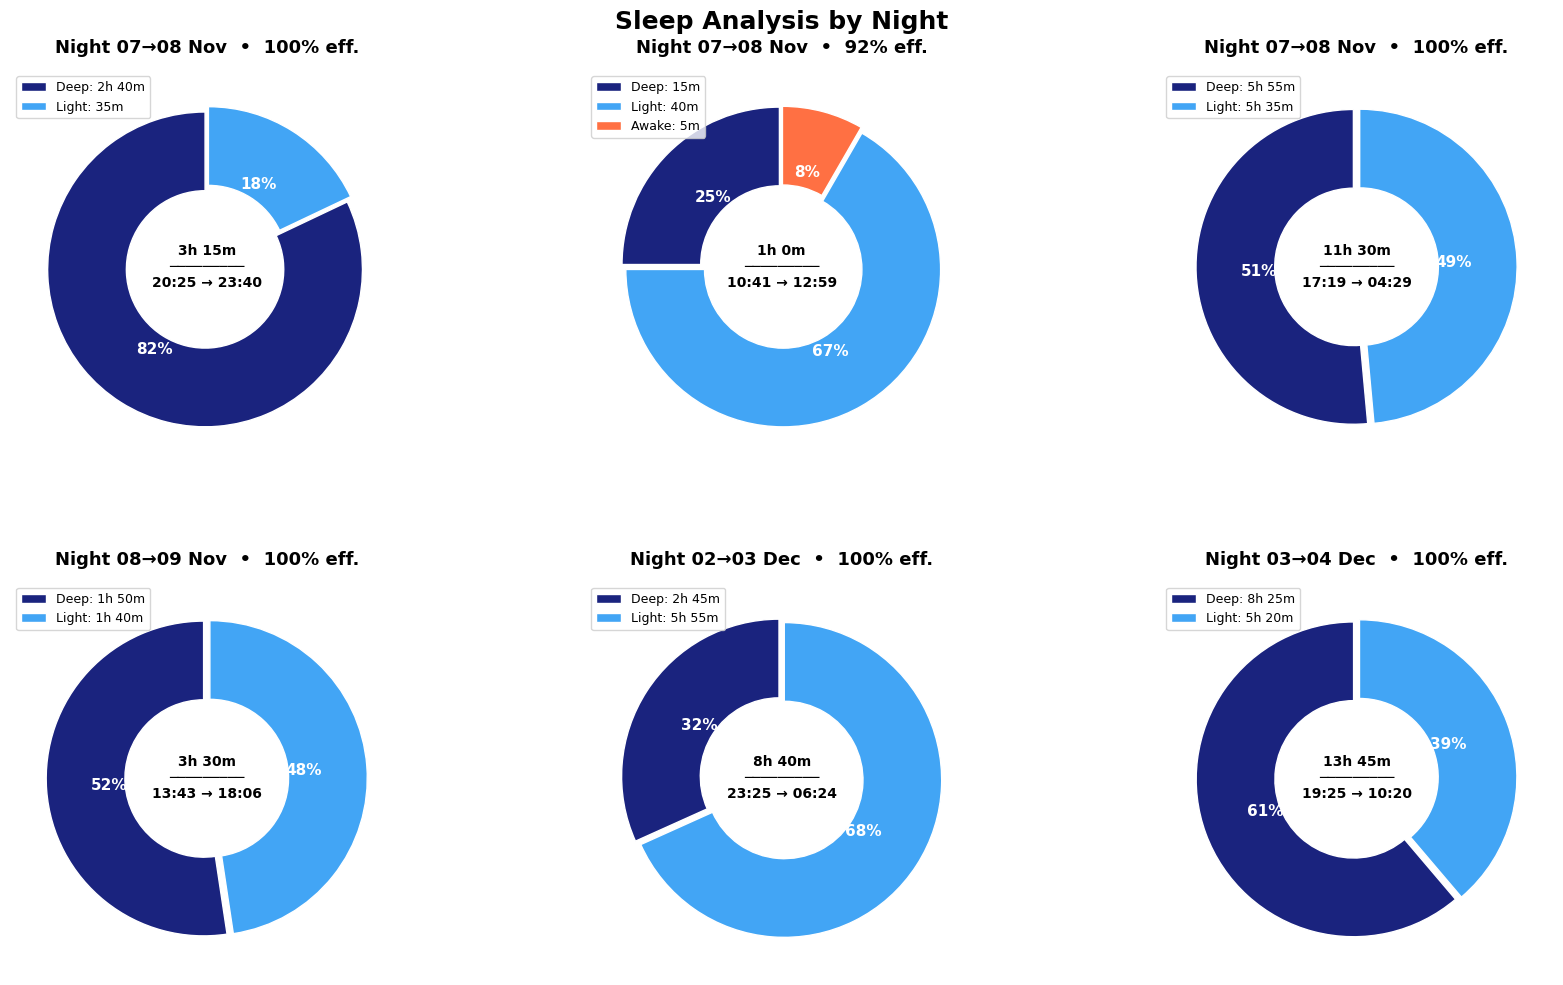


✅ Saved: night_donuts.png


In [25]:
# Clear any previous figures
plt.close('all')

if not nights_data:
    print("⚠️ No data to display")
else:
    # Determine grid layout
    n_nights = len(nights_data)
    cols = min(3, n_nights)
    rows = (n_nights + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    fig.suptitle('Sleep Analysis by Night', fontsize=18, fontweight='bold')
    
    # Flatten axes
    if n_nights == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    colors = ['#1a237e', '#42a5f5', '#ff7043']  # Deep, Light, Awake
    
    for idx, night in enumerate(nights_data):
        ax = axes[idx]
        
        # Data for donut chart
        sizes = [night['deep'], night['light'], night['awake']]
        labels_pie = ['Deep', 'Light', 'Awake']
        
        # Remove zero slices
        non_zero = [(s, l, c) for s, l, c in zip(sizes, labels_pie, colors) if s > 0]
        if non_zero:
            sizes, labels_pie, pie_colors = zip(*non_zero)
        else:
            continue
        
        # Donut chart
        wedges, texts, autotexts = ax.pie(
            sizes, 
            labels=None,
            autopct=lambda pct: f'{pct:.0f}%' if pct > 5 else '',
            colors=pie_colors,
            startangle=90,
            explode=[0.02] * len(sizes),
            wedgeprops=dict(width=0.5, edgecolor='white'),
            textprops={'fontsize': 11, 'fontweight': 'bold', 'color': 'white'}
        )
        
        # Center text: total duration + times
        center_text = (
            f"{format_duration(night['total'])}\n"
            f"─────────\n"
            f"{night['bedtime'].strftime('%H:%M')} → {night['wake_time'].strftime('%H:%M')}"
        )
        ax.text(0, 0, center_text, ha='center', va='center', fontsize=10, fontweight='bold')
        
        # Title with efficiency
        ax.set_title(f"Night {night['label']}  •  {night['efficiency']:.0f}% eff.", 
                     fontsize=13, fontweight='bold', pad=12)
        
        # Legend with durations only
        legend_labels = [f"{l}: {format_duration(s)}" for l, s in zip(labels_pie, sizes)]
        ax.legend(wedges, legend_labels, loc='upper left', fontsize=9)
    
    # Hide empty axes
    for idx in range(n_nights, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.3)
    plt.savefig('night_donuts.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Saved: night_donuts.png")

## 📈 Sleep Duration Summary by Night

Comparative bar chart of all nights.

In [ ]:
if not nights_data:
    print("⚠️ No data to display")
else:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    x_pos = range(len(nights_data))
    labels = [n['label'] for n in nights_data]
    
    # Chart 1: Total duration
    ax1 = axes[0]
    total_hours = [n['total'] / 60 for n in nights_data]
    bars = ax1.bar(x_pos, total_hours, color='#5c6bc0', alpha=0.8, edgecolor='black')
    ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, label='Recommended (7h)')
    ax1.axhline(y=8, color='green', linestyle='--', alpha=0.3)
    ax1.set_ylabel('Total Sleep (hours)', fontsize=11)
    ax1.set_title('Sleep Duration per Night', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, max(total_hours) + 1)
    
    for bar, hours in zip(bars, total_hours):
        if hours > 0:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f'{hours:.1f}h', ha='center', va='bottom', fontsize=9)
    
    # Chart 2: Composition
    ax2 = axes[1]
    deep_h = [n['deep'] / 60 for n in nights_data]
    light_h = [n['light'] / 60 for n in nights_data]
    awake_h = [n['awake'] / 60 for n in nights_data]
    
    ax2.bar(x_pos, deep_h, label='Deep', color='#1a237e', alpha=0.9)
    ax2.bar(x_pos, light_h, bottom=deep_h, label='Light', color='#42a5f5', alpha=0.9)
    ax2.bar(x_pos, awake_h, bottom=[d + l for d, l in zip(deep_h, light_h)], 
            label='Awake', color='#ff7043', alpha=0.9)
    
    ax2.set_xlabel('Night', fontsize=11)
    ax2.set_ylabel('Hours', fontsize=11)
    ax2.set_title('Sleep Composition by Night', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(axis='y', alpha=0.3)
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('daily_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Saved: daily_summary.png")

## 📋 Last Night Details

Detailed information about the most recent sleep session.

In [26]:
if nights_data:
    last = nights_data[-1]
    
    print("="*50)
    print(f"  LAST NIGHT: {last['label']}")
    print("="*50)
    print(f"")
    print(f"  Bedtime:     {last['bedtime'].strftime('%H:%M')} UTC")
    print(f"  Wake:        {last['wake_time'].strftime('%H:%M')} UTC")
    print(f"")
    print(f"  Total duration:  {format_duration(last['total'])}")
    print(f"  - Deep Sleep:    {format_duration(last['deep'])} ({last['deep']/last['total']*100:.0f}%)")
    print(f"  - Light Sleep:   {format_duration(last['light'])} ({last['light']/last['total']*100:.0f}%)")
    print(f"  - Awake:         {format_duration(last['awake'])} ({last['awake']/last['total']*100:.0f}%)")
    print(f"")
    print(f"  Efficiency:      {last['efficiency']:.0f}%")
    print(f"  Records:         {last['records']}")
    print("="*50)
else:
    print("⚠️ No data available")

  LAST NIGHT: 03→04 Dec

  Bedtime:     19:25 UTC
  Wake:        10:20 UTC

  Total duration:  13h 45m
  - Deep Sleep:    8h 25m (61%)
  - Light Sleep:   5h 20m (39%)
  - Awake:         0m (0%)

  Efficiency:      100%
  Records:         16
